# Random walk kernels experiments

### Imports

In [156]:
from sage.all import *
import networkx as nx
import grakel as gk
import numpy as np
from typing import Optional
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx
from torch_geometric.data import Data
import scipy.sparse as sp
import matplotlib.pyplot as plt

### Downloading Datasets

In [157]:

mutag = TUDataset(root="data/TUDataset", name="MUTAG")
print(len(mutag), mutag.num_classes)
print(mutag[int(0)])

188 2
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


### Random Graph Generator

In [158]:
def graph_gen(kind: str, n: int, seed: Optional[int] = None):
    """
    er for Erdos-Renyi
    ba for Barabasi-Albert
    ws for Watts-Strogtz (small-world)
    """
    if seed is None:
        seed = np.random.SeedSequence().entropy
    
    if kind == "er": #Erdos-Renyi
        #p = 2.0/n gives us a moderately sparse graph:
        #E[deg] ≈ (n - 1) * p ≈ 2
        return nx.erdos_renyi_graph(n=n, p=2.0/n, seed=seed)
    
    if kind == "ba": #Barabasi-Albert (preferential attachment)
        # Each new node connects to m = max(1, n // 20) existing nodes.
        # This yields a scale-free graph with hubs.
        return nx.barabasi_albert_graph(n=n, m=max(1, n // 20), seed=seed)
    
    if kind == "ws": #Watts-Strogtz (small-world)
        # Start with a ring where each node connects to k neighbors, then rewire edges with p = 0.1.
        # This keeps high clustering while creating short average paths.
        k = max(2, (n // 10) | 1)
        p = 0.1
        return nx.watts_strogatz_graph(n=n, k=k, p=p, seed=seed)

    if kind == "sbm":
        # Stochastic Block Model with 2 groups.
        # Connect nodes within the same group with p_in = 0.15,
        # and across groups with p_out = 0.02 (weaker connections).
        sizes = [n//2, n - n//2]
        p_in, p_out = int(0.15), int(0.02)
        P = [
            [p_in,  p_out],
            [p_out, p_in]
        ]
        return nx.stochastic_block_model(sizes, P, seed=seed)
    
    raise ValueError(f"unknown kind: {kind}")


### Visualising graph and adjacency matrix

In [159]:
#convert PyG graph (for instance, from MUTAG dataset) or nx graph to sage graph
def to_sage_graph(g, undirected=True):
    if isinstance(g, Data):
        data = g.edge_index.cpu().numpy()
        sg = Graph(list(zip(data[0], data[1])))
        if undirected:
            return sg.to_undirected()
        else: 
            return sg
        
    elif isinstance(g, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph)):
        return Graph(list(g.edges()))
    
    raise TypeError(f"Unsupported type: {type(g)}")

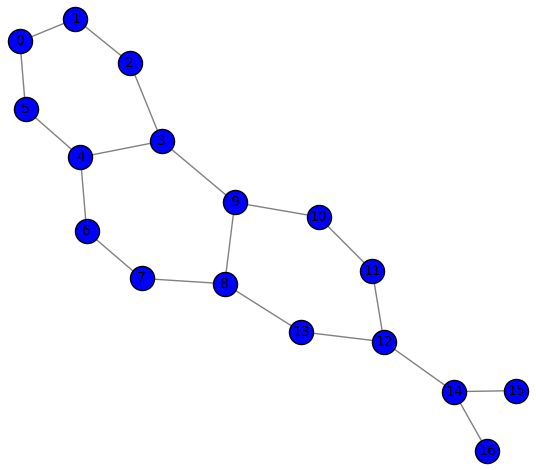

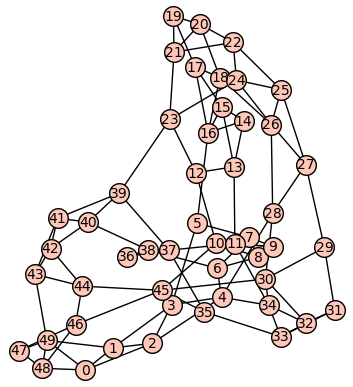

In [160]:
sg_mutag = to_sage_graph(mutag[int(0)])
sg_mutag.plot(vertex_color="blue", edge_color="gray", vertex_size=300, layout="spring").show()

sg_ws = to_sage_graph(graph_gen("ws", int(50)))
sg_ws.show()

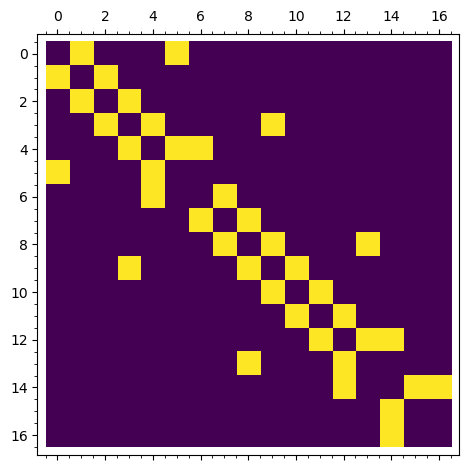

In [161]:
A_mutag = sg_mutag.adjacency_matrix()
matrix_plot(A_mutag, cmap='viridis')

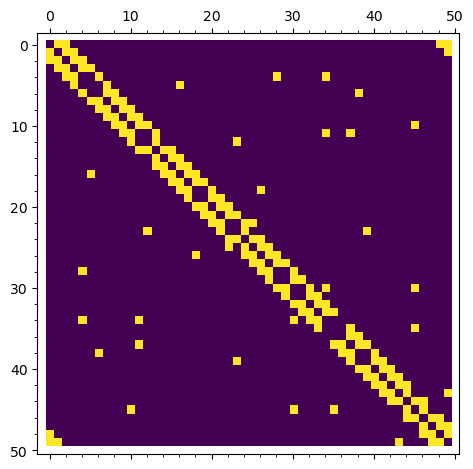

In [162]:
A_ws = sg_ws.adjacency_matrix()
matrix_plot(A_ws, cmap='viridis')

## Random Walk Kernels

We will implement Random-Walk Kernels computation based on [Fast Computation of Graph Kernels](https://proceedings.neurips.cc/paper_files/paper/2006/file/e37b08dd3015330dcbb5d6663667b8b8-Paper.pdf) by S.V.N. Vishwanathan, Karsten M. Borgwardt, Nicol N. Schraudolph

By defenitions $k(G, G') = q_x^T(I - \lambda * W_x)^{-1}p_x$, where $W_x = A \bigotimes A'$ (A - normalized adjacency matrix), $q_x = q \bigotimes q', p_x = p \bigotimes p'$

In [189]:
def norm_adj_matrix(g: Graph):
    P = g.adjacency_matrix()
    d_inv = []
    for d in g.degree():
        if(d == 0):
            d_inv.append(0)
        else:
            d_inv.append(1/ d)
    
    D_inv = diagonal_matrix(d_inv, sparse=False)
    return P * D_inv

def rw_kernel(g1: Graph, g2: Graph, lmbd: float, p1, p2, q1, q2):
    A1 = np.array(norm_adj_matrix(g1), dtype=float)
    A2 = np.array(norm_adj_matrix(g2), dtype=float)

    n1 = len(g1.degree())
    n2 = len(g2.degree())
    p_x = np.kron(p1, p2)
    q_x = np.kron(q1, q2)

    W_x = np.kron(A1, A2)
    M = np.eye(n1 * n2) - lmbd * W_x
    X = np.linalg.solve(M, p_x)
    return float(q_x @ X)

In [190]:
g1 = to_sage_graph(mutag[int(0)])
g2 = to_sage_graph(mutag[int(1)])

n1 = int(g1.num_verts())
n2 = int(g2.num_verts())
p1 = np.full(n1, float(1.0) / n1)
q1 = np.full(n1, float(1.0) / n1)
p2 = np.full(n2, float(1.0) / n2)
q2 = np.full(n2, float(1.0) / n2)

k = rw_kernel(g1, g2, float(0.1), p1, p2, q1, q2)
print(k)

0.005027652086475616


### Efficient Computations

#### Sylvester Equasion Methods

#### Conjugate Gradient Methods

#### Fixed-Point Iterations

### Benchmark and Experiments